In [20]:
import sys
sys.path = [p for p in sys.path if "ParaView" not in p]


import torch as pt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from flowtorch import DATASETS
from flowtorch.data import FOAMDataloader, mask_box
from flowtorch.rom import CNM, SVDEncoder

# increase resolution of plots
mpl.rcParams['figure.dpi'] = 160


In [ ]:
# Load and prepare the dataset from your OpenFOAM case 

from pathlib import Path

# Load the dataset from your OpenFOAM case
path = str(Path("~/OpenFOAM/run/cylinder_2D_Re200").expanduser())
loader = FOAMDataloader(path)
times = loader.write_times

# Filter times for the DMD analysis
window_times = [t for t in times if float(t) >= 4.0]

# Load vertices and create spatial mask
vertices = loader.vertices[:, :2]
mask = mask_box(vertices, lower=[0.1, -1], upper=[0.75, 1])

# Assemble the data matrix for the velocity vector of the cylinder 2D case

data_matrix = pt.zeros((mask.sum().item(), len(window_times)), dtype=pt.float64)

for i, time in enumerate(window_times):
    velocity = loader.load_snapshot("U", time)  # shape: [n_points, 3]
    velocity_magnitude = pt.linalg.norm(velocity, dim=1)  # shape: [n_points]
    masked_velocity = pt.masked_select(velocity_magnitude, mask)  # shape: [masked_points]
    data_matrix[:, i] = masked_velocity

INFO:flowtorch.data.foam_dataloader:Loading precomputed cell centers and volumes from processor0/constant
INFO:flowtorch.data.foam_dataloader:Loading precomputed cell centers and volumes from processor1/constant


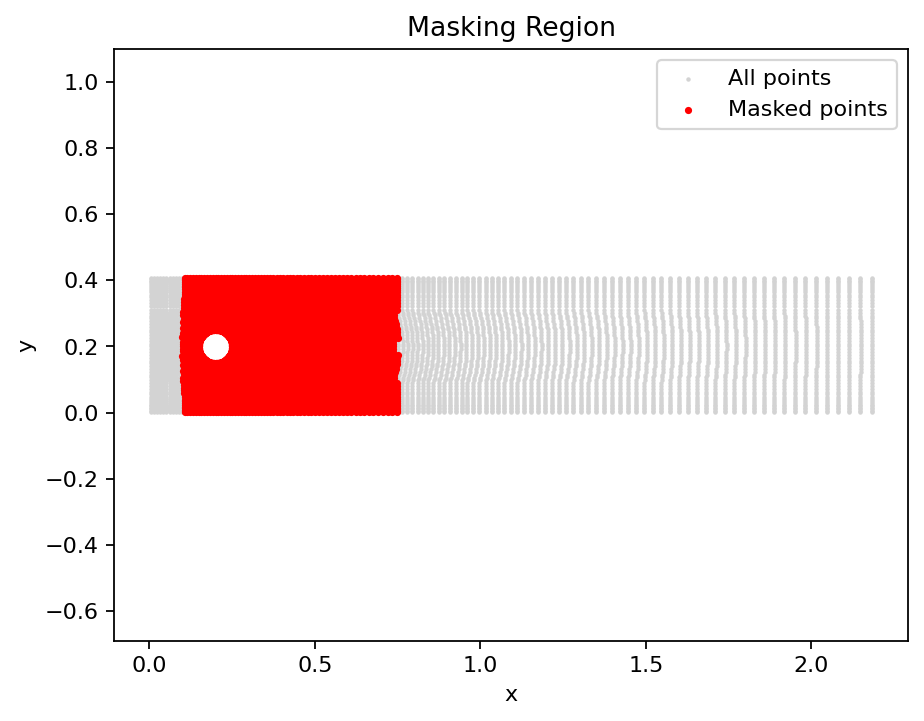

Total mesh points: 9800
Masked points: 5746


In [22]:
# Masking points in a 2D cylinder dataset using a box region

vertices = loader.vertices[:, :2]  # just x, y
mask = mask_box(vertices, lower=[0.1, -1], upper=[0.75, 1])

plt.scatter(vertices[:, 0], vertices[:, 1], s=1, c='lightgray', label='All points')
plt.scatter(vertices[mask][:, 0], vertices[mask][:, 1], s=5, c='red', label='Masked points')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.title('Masking Region')
plt.axis('equal'); plt.show()
print(f"Total mesh points: {vertices.shape[0]}")
print(f"Masked points: {mask.sum().item()}")


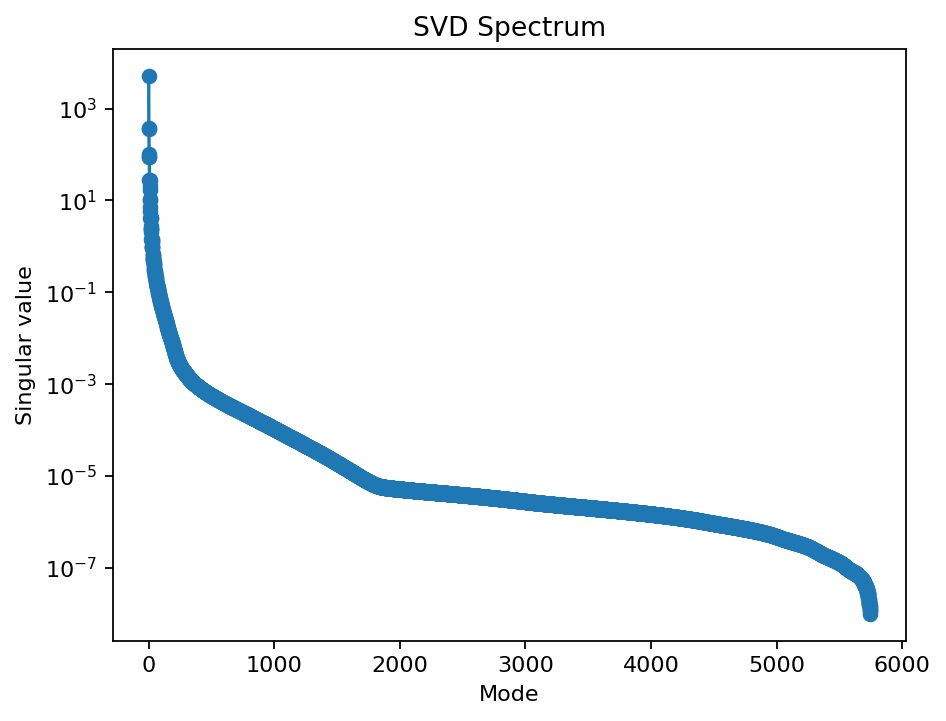

In [23]:
# Compute SVD spectrum
U, S, Vh = pt.linalg.svd(data_matrix, full_matrices=False)
plt.semilogy(S.cpu().numpy(), 'o-')
plt.xlabel("Mode")
plt.ylabel("Singular value")
plt.title("SVD Spectrum")
plt.show()

In [24]:

# Encode the data matrix using SVD  


encoder = SVDEncoder(rank=30)

# Check for invalid values
print("Has NaNs:", pt.isnan(data_matrix).any())
print("Has Infs:", pt.isinf(data_matrix).any())

# Force data onto CPU to avoid backend crash
data_matrix = data_matrix.cpu()
data_matrix = data_matrix.contiguous()
print(data_matrix.shape)

# Train the encoder and encode the data matrix
info = encoder.train(data_matrix)
reduced_state = encoder.encode(data_matrix)

print("Training time: {:.4f}s".format(info["execution_time"]))


Has NaNs: tensor(False)
Has Infs: tensor(False)
torch.Size([5746, 8001])
Training time: 62.3108s


In [25]:
# Create and train the CNM model

dt = float(times[1]) - float(times[0])
cnm = CNM(reduced_state, encoder, dt, n_clusters=40, model_order=4)
print(f"Time step between snapshots: {dt}s")

Time step between snapshots: 0.002s


In [26]:
# Plot the clusters and their reconstructions

clusters = cnm.cluster_centers
clusters_reconstructed = encoder.decode(pt.from_numpy(clusters.T))

In [27]:
# Function to add a mode to the plot
def add_mode(ax, mode, title, every=4):
    ax.tricontourf(x[::every], y[::every], mode[::every], levels=15, cmap="jet")
    ax.tricontour(x[::every], y[::every], mode[::every], levels=15, linewidths=0.1, colors='k')
    ax.add_patch(plt.Circle((0.2, 0.2), 0.05, color='k'))
    ax.set_aspect("equal", 'box')
    ax.set_title(title)

x = pt.masked_select(vertices[:, 0], mask)
y = pt.masked_select(vertices[:, 1], mask)

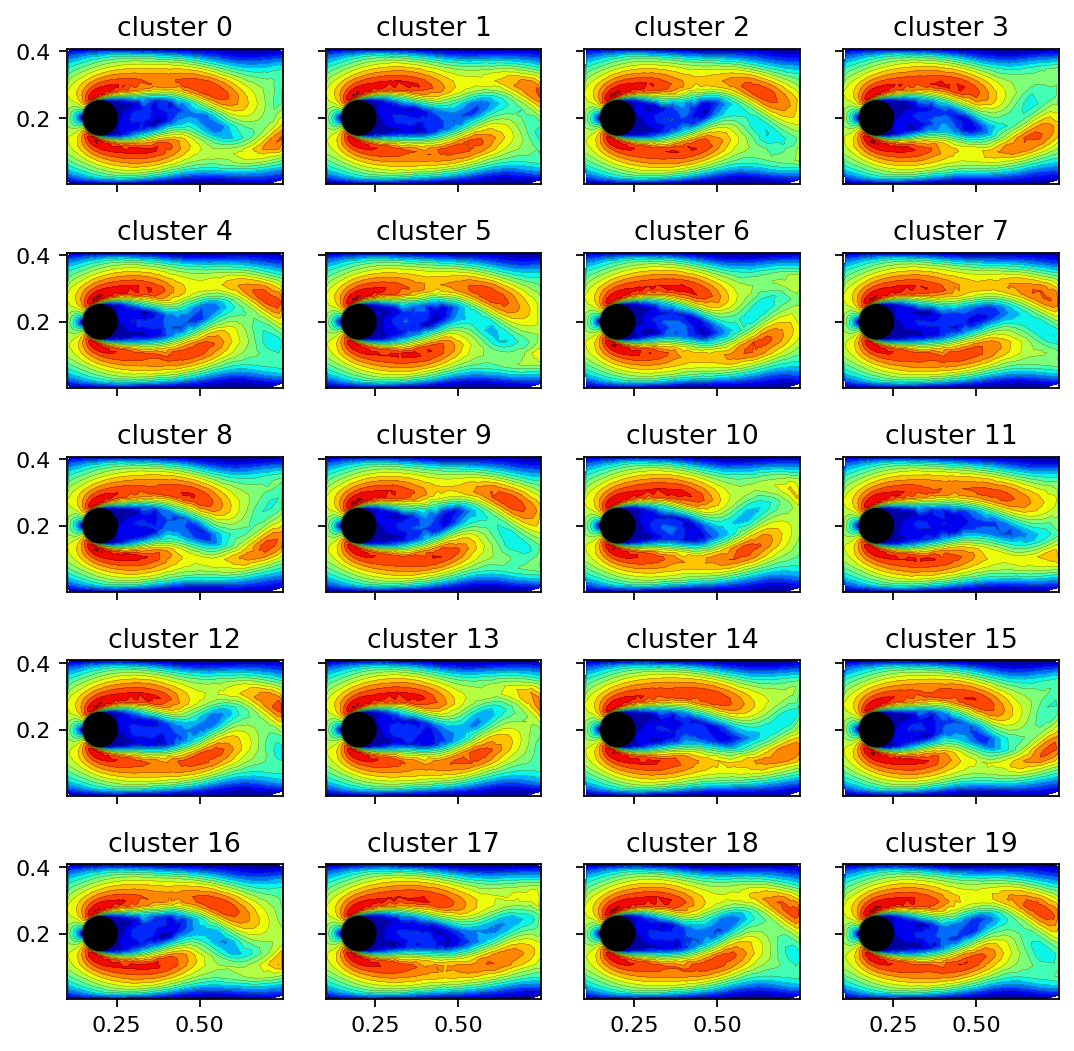

In [28]:
fig, axarr = plt.subplots(5, 4, figsize=(8, 8), sharex=True, sharey=True)
count = 0
for row in range(5):
    for col in range(4):
        add_mode(axarr[row, col], clusters_reconstructed[:, count], f"cluster {count}")
        count += 1
plt.show()

In [29]:
# Predict the next state using the CNM model
reduced_prediction = cnm.predict_reduced(reduced_state[:, :4], 1.0, dt/4)
visited_prediction = cnm._cluster.predict(reduced_prediction.T.numpy())
org_cluster_sequence = cnm.cluster_centers[cnm.visited_clusters]

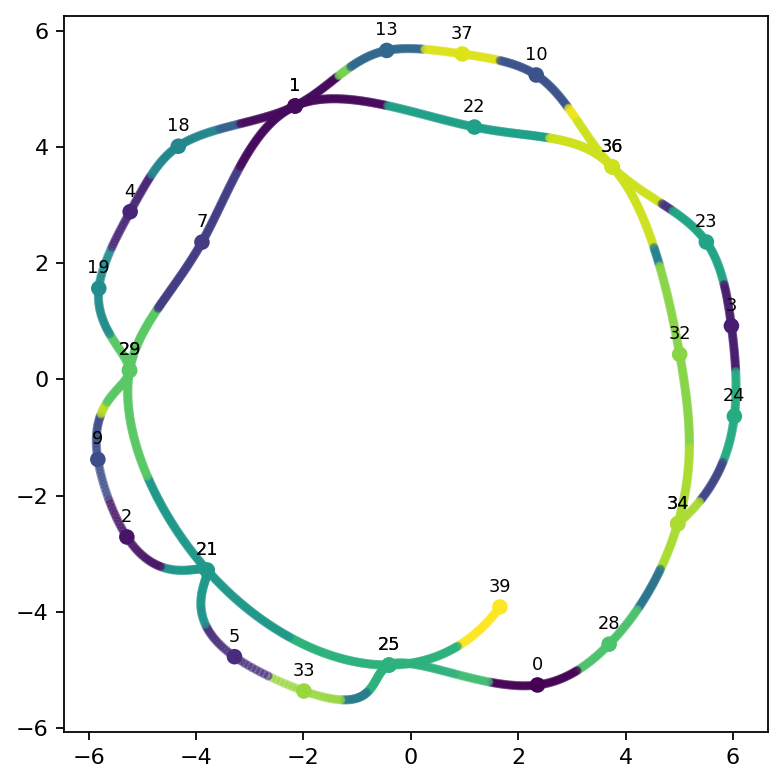

In [30]:
fig, ax = plt.subplots(figsize=(5, 5))

# plot the visited centers and color them by their label
xc = org_cluster_sequence[:, 1]
yc = org_cluster_sequence[:, 2]
ax.scatter(xc, yc, c=cnm.visited_clusters)

# plot the interpolated centers and color them by their label
xp = reduced_prediction[1, :]
yp = reduced_prediction[2, :]
ax.quiver(xp[:-1], yp[:-1], xp[1:]-xp[:-1], yp[1:]-yp[:-1], scale_units='xy', angles='xy', scale=1, color="k", alpha=0.1)
ax.scatter(xp, yp, c=visited_prediction, s=10, alpha=0.5)

ax.margins(x=0.05, y=0.05)

# annotate each visited center with its label
for i, lbl in enumerate(cnm.visited_clusters[:len(xc)]):
    ax.annotate(
        text=str(lbl),
        xy=(xc[i], yc[i]),
        xytext=(0, 5),              # shift up by 5 points
        textcoords="offset points", # data→pixel offset
        ha="center",
        va="bottom",
        fontsize=8,
        color="black",
    )

plt.tight_layout()
plt.show()

In [31]:
prediction = cnm.predict(data_matrix[:, :5], 1.0, dt)

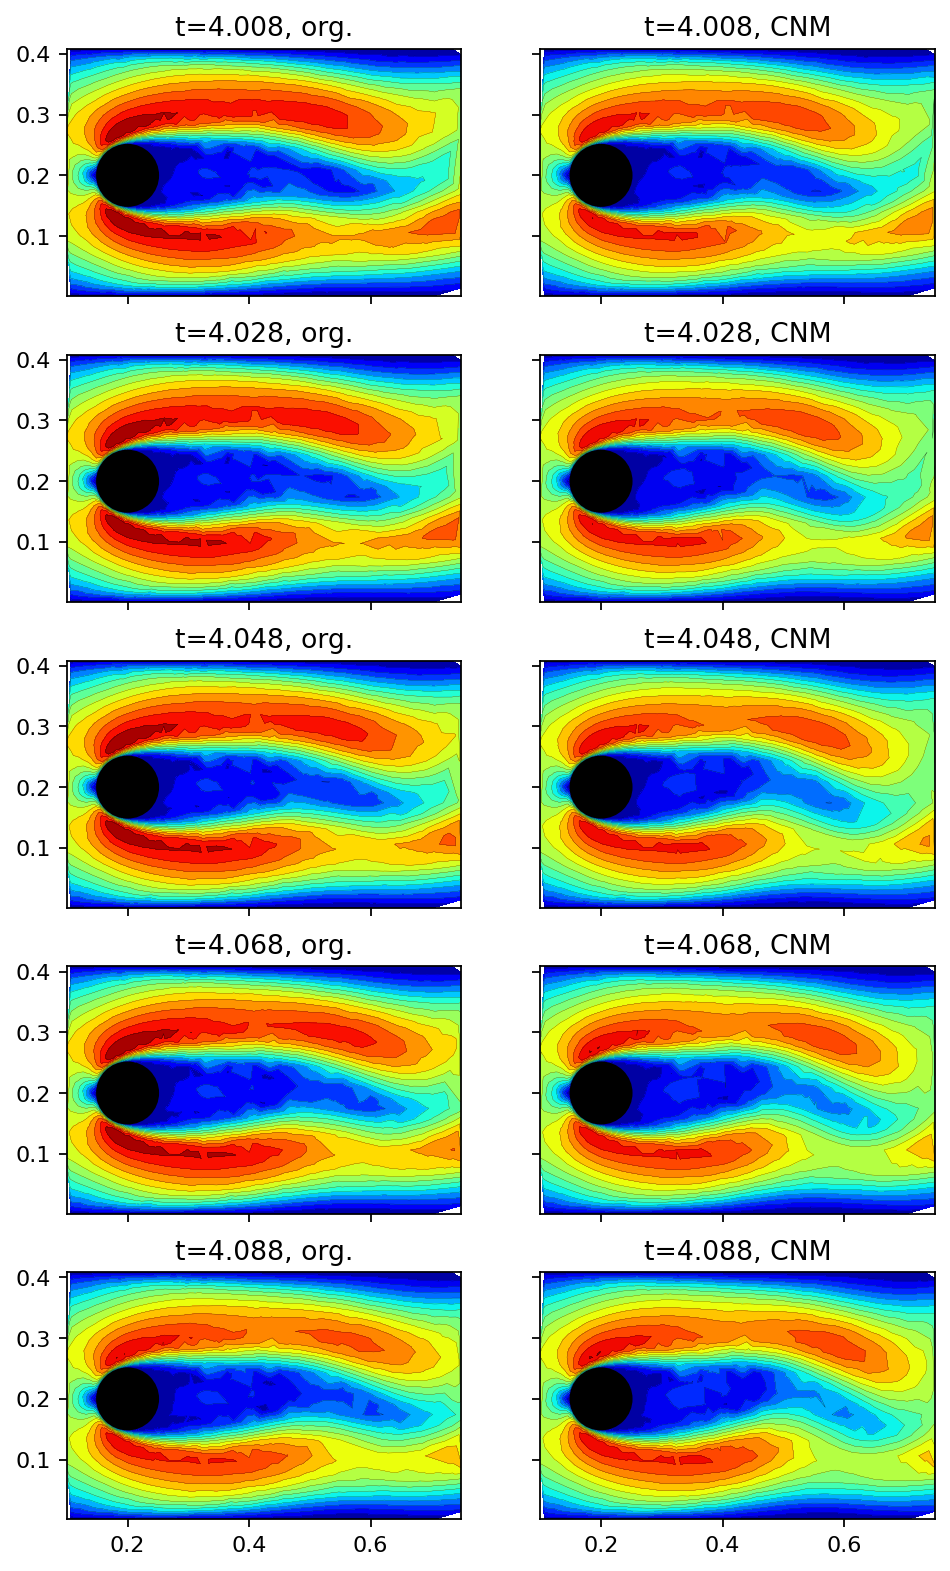

In [32]:
fig, axarr = plt.subplots(5, 2, figsize=(7, 12), sharex=True, sharey=True)
count = 0
for row in range(5):
    add_mode(axarr[row, 0], data_matrix[:, 4+count], f"t={window_times[4+count]}, org.")
    add_mode(axarr[row, 1], prediction[:, count], f"t={window_times[4+count]}, CNM")
    count += 10
plt.show()


## Mean Squared Error & Structural Similarity Index

In [33]:

import numpy as np

def compute_mse(original, prediction):
    return np.mean((original - prediction)**2)


In [34]:
from skimage.metrics import structural_similarity as ssim

def compute_ssim(original, prediction):
    score, _ = ssim(original, prediction, data_range=original.max() - original.min(), full=True)
    return score


In [35]:
import matplotlib.pyplot as plt

def plot_error_field(original, prediction, x, y, title="Error Field"):
    error = original - prediction
    plt.tricontourf(x, y, error, levels=30, cmap="coolwarm")
    plt.title(title)
    plt.colorbar(label="Error")
    plt.axis('equal')
    plt.show()


Snapshot 0: MSE = 0.0003, SSIM = 0.9959


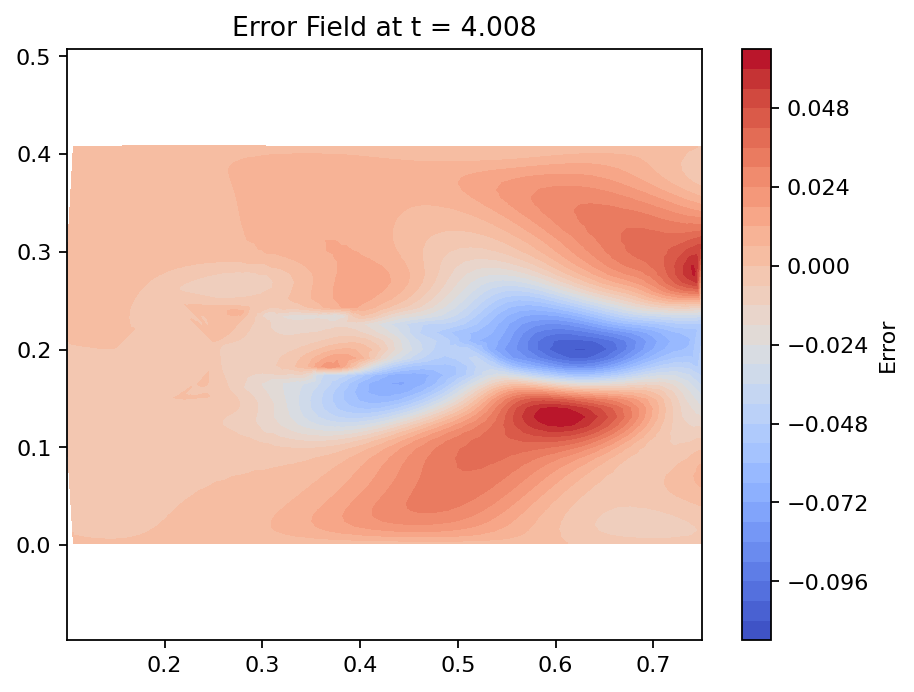

Snapshot 1: MSE = 0.0005, SSIM = 0.9943


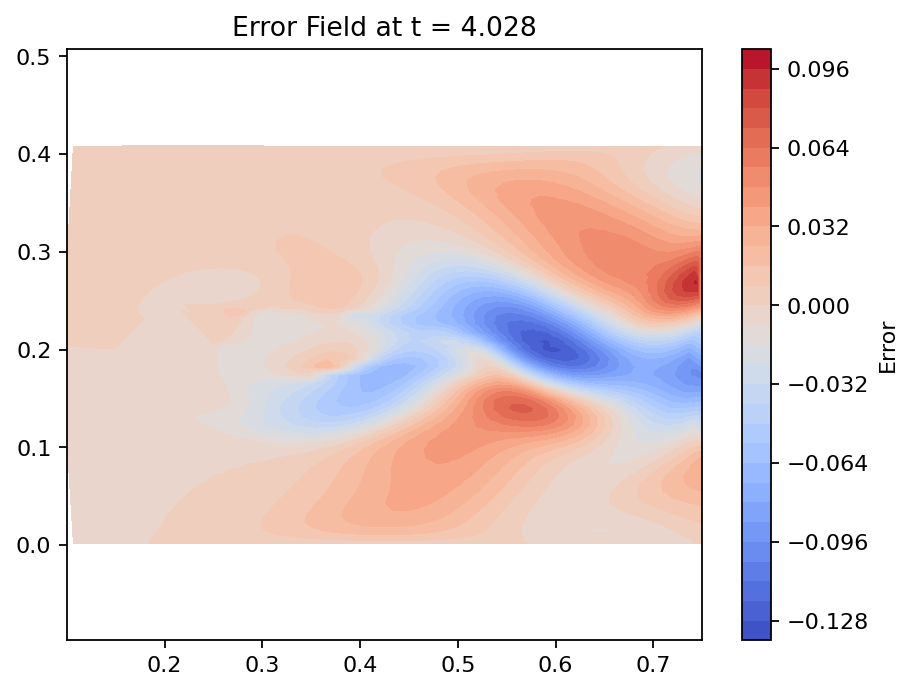

Snapshot 2: MSE = 0.0009, SSIM = 0.9880


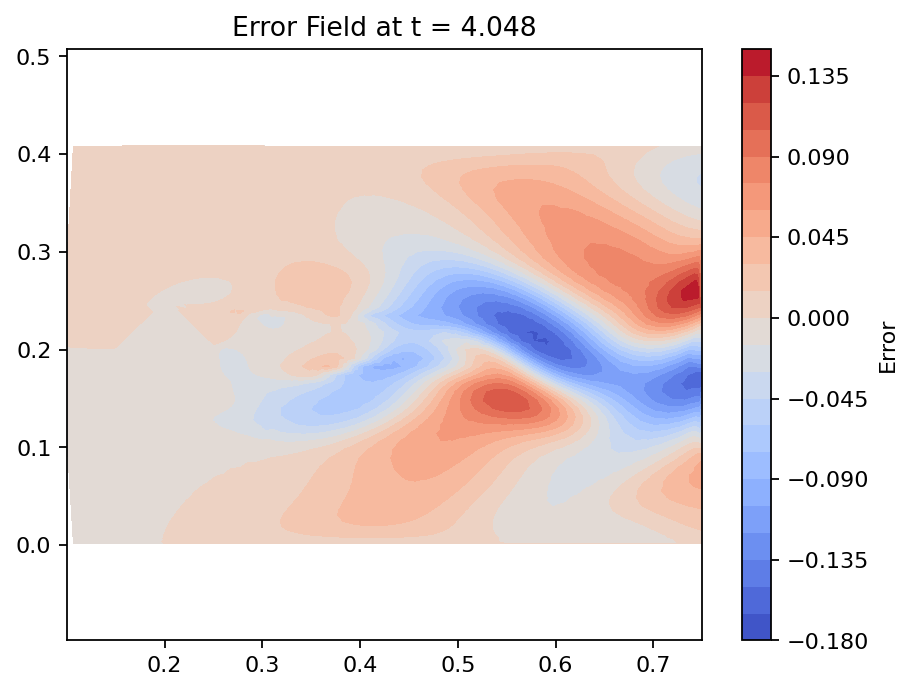

Snapshot 3: MSE = 0.0016, SSIM = 0.9780


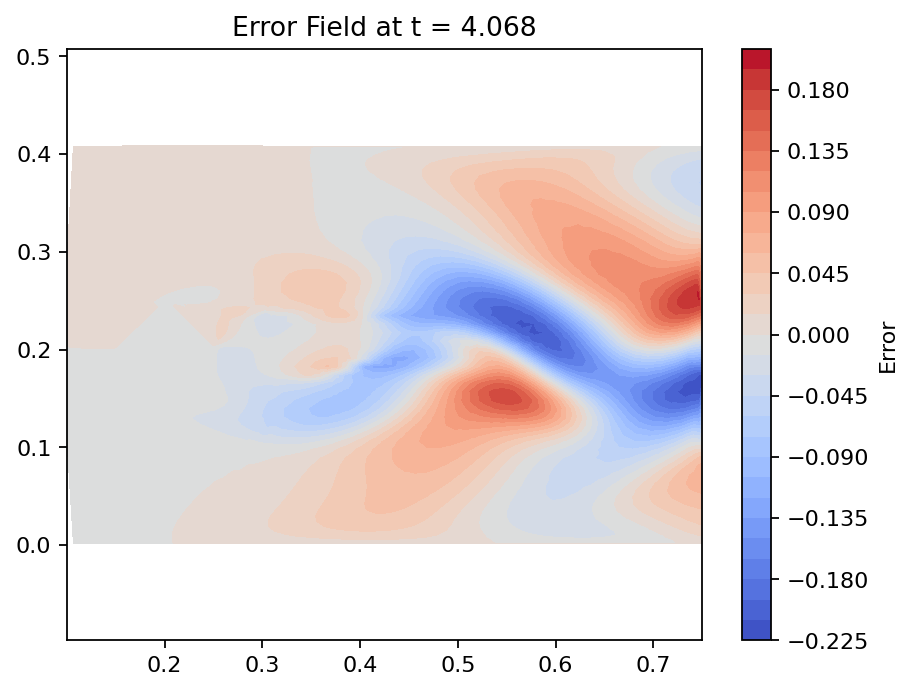

Snapshot 4: MSE = 0.0026, SSIM = 0.9655


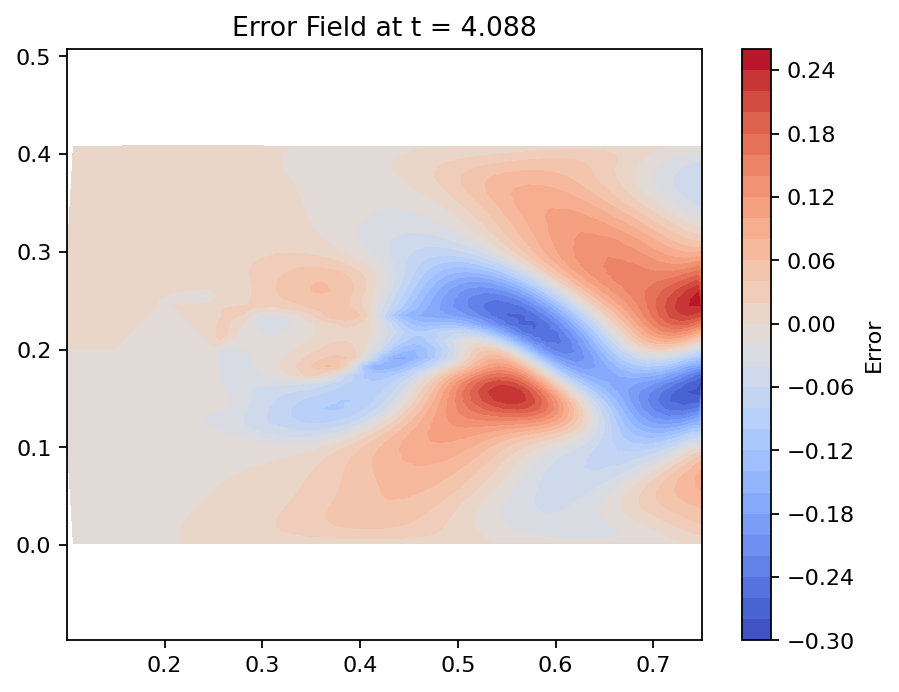

In [36]:
for i in range(5):  # or more, depending on data
    org = data_matrix[:, 4 + 10*i].numpy()
    pred = prediction[:, i].numpy()
    
    mse = compute_mse(org, pred)
    ssim_score = compute_ssim(org, pred)

    print(f"Snapshot {i}: MSE = {mse:.4f}, SSIM = {ssim_score:.4f}")
    plot_error_field(org, pred, x, y, title=f"Error Field at t = {window_times[4 + 10*i]}")
